In [1]:
import json
import numpy as np
import pandas as pd
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# load loss files
loss_files = glob('./losses/*.json')

toy_losses = []
mnist_losses = []
for lf in loss_files:
    if 'mnist' in lf:
        mnist_losses.append(lf)
    else:
        toy_losses.append(lf)
print(mnist_losses)
print(toy_losses)

['./losses\\draw_mnist_10.json', './losses\\flow_mnist_10.json', './losses\\lvae_mnist_10.json', './losses\\vae_mnist_10.json']
['./losses\\flow_8gaussians_10.json', './losses\\flow_checkerboard_10.json', './losses\\lvae_8gaussians_10.json', './losses\\lvae_checkerboard_10.json', './losses\\vae_8gaussians_10.json', './losses\\vae_checkerboard_10.json']


In [3]:
def compute_params(loss):
    N = loss.shape[0]
    min_, max_, last = [], [], []
    
    first, exceeds = [], []
    for i in range(N):
        # remove nans from test loss
        tll = loss[i]
        tll = np.abs(tll[~np.isnan(tll)])

        if len(tll):
            min_.append(tll.min())
            max_.append(tll.max())
            last.append(tll[-1])

            first_ = tll[:5].mean()
            first.append(first_)
            exceeds.append(np.sum(first_ < tll[5:]))
    min_ = np.array(min_)
    max_ = np.array(max_)
    last = np.array(last)
    first = np.array(first)
    exceeds = np.array(exceeds)

    # store parameters
    return {
        'min': [min_.mean(), min_.std()],
        'max': [max_.mean(), max_.std()],
        'last': [last.mean(), last.std()],
        'first': [first.mean(), first.std()],
        'exceeds': [exceeds.mean(), exceeds.std()],
    }

In [4]:
def get_metric_mean(metrics, keys):
    return np.array([metrics[key][0] for key in keys])

def get_metric_std(metrics, keys):
    std = np.array([metrics[key][1] for key in keys])
    std[np.array(xlabels) == 'exceeds'] = 0
    return std

## Inspect Convergence on Toy Data

In [5]:
metrics_gauss = {}
metrics_check = {}
for tl in toy_losses:
    with open(tl, 'r') as f:
        losses = json.load(f)
    name = tl.split('\\')[-1].replace('.json', '')
    model, dataname, _ = name.split('_')

    #
    test_loss = np.array(losses['val'])
    params = compute_params(test_loss)
    if dataname =='8gaussians':
        metrics_gauss[model] = params
    elif dataname == 'checkerboard':
        metrics_check[model] = params

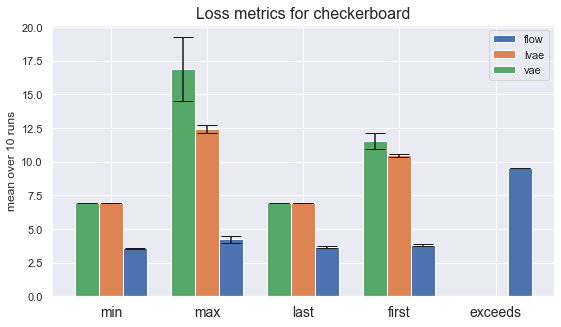

In [21]:
# plotting options
xlabels = ['min', 'max', 'last', 'first', 'exceeds']
xs = np.arange(len(xlabels))

# for checkerboard
plt.figure(figsize=(9, 5))
n = len(metrics_check)
width = 1/(n + 1)
for i, model in enumerate(metrics_check):
    params = get_metric_mean(metrics_check[model], xlabels)
    err = get_metric_std(metrics_check[model], xlabels)
    plt.bar(xs-width*(i-(n-1)/2), params, yerr=err, width=width, label=model, capsize=10)
plt.title('Loss metrics for checkerboard', fontsize=16)
plt.ylabel('mean over 10 runs')
plt.xticks(xs, xlabels, fontsize=14)
plt.legend()
plt.savefig('./losses/metrics_checkerboard.png')
plt.show()

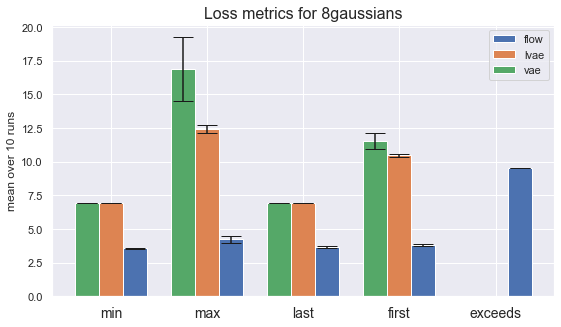

In [22]:
# plotting options
xlabels = ['min', 'max', 'last', 'first', 'exceeds'] # , 
xs = np.arange(len(xlabels))

# for 8gaussians
plt.figure(figsize=(9, 5))
n = len(metrics_gauss)
width = 1/(n + 1)
for i, model in enumerate(metrics_gauss):
    params = get_metric_mean(metrics_check[model], xlabels)
    err = get_metric_std(metrics_check[model], xlabels)
    plt.bar(xs-width*(i-(n-1)/2), params, yerr=err, width=width, label=model, capsize=10)
plt.title('Loss metrics for 8gaussians', fontsize=16)
plt.ylabel('mean over 10 runs')
plt.xticks(xs, xlabels, fontsize=14)
plt.legend()
plt.savefig('./losses/metrics_8gaussians.png')
plt.show()

In [15]:
df = pd.DataFrame()
for tl in toy_losses:
    with open(tl, 'r') as f:
        losses = json.load(f)
    
    name = tl.split('\\')[-1].replace('.json', '')
    model, dataname, _ = name.split('_')

    loss = np.array(losses['val'])
    dict_ = {
        'model': model,
        'data': dataname,
    }
    params = compute_params(loss)
    for key in params.keys():
        dict_[key] = params[key][0]
    
    df = df.append(dict_, ignore_index=True)
df = df.sort_values('data')
print(df.round(2).to_markdown())

|    | model   | data         |   min |   max |   last |   first |   exceeds |
|---:|:--------|:-------------|------:|------:|-------:|--------:|----------:|
|  0 | flow    | 8gaussians   |  2.91 |  3.36 |   2.95 |    3.06 |       9.9 |
|  2 | lvae    | 8gaussians   |  5.82 | 11.04 |   5.82 |    9.29 |       0   |
|  4 | vae     | 8gaussians   |  5.82 | 16.11 |   5.82 |   10.3  |       0   |
|  1 | flow    | checkerboard |  3.58 |  4.23 |   3.63 |    3.79 |       9.5 |
|  3 | lvae    | checkerboard |  6.92 | 12.42 |   6.92 |   10.48 |       0   |
|  5 | vae     | checkerboard |  6.91 | 16.86 |   6.91 |   11.52 |       0   |


## Inspect Convergence on MNIST 

In [16]:
metrics_mnist = {}
for tl in mnist_losses:
    with open(tl, 'r') as f:
        losses = json.load(f)
    name = tl.split('\\')[-1].replace('.json', '')
    model, dataname, _ = name.split('_')

    #
    test_loss = np.array(losses['val'])
    params = compute_params(test_loss)
    metrics_mnist[model] = params

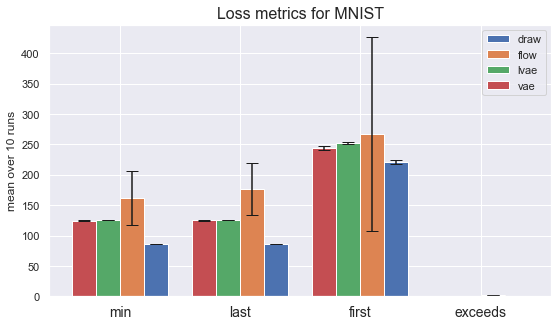

In [23]:
# plotting options
xlabels = ['min', 'last', 'first', 'exceeds'] #  'max', 
xs = np.arange(len(xlabels))

# for mnist
plt.figure(figsize=(9, 5))
n = len(metrics_mnist)
width = 1/(n + 1)
for i, model in enumerate(metrics_mnist):
    params = get_metric_mean(metrics_mnist[model], xlabels)
    err = get_metric_std(metrics_mnist[model], xlabels)
    plt.bar(xs-width*(i-(n-1)/2), params, yerr=err, width=width, label=model, capsize=6)
plt.title('Loss metrics for MNIST', fontsize=16)
plt.ylabel('mean over 10 runs')
plt.xticks(xs, xlabels, fontsize=14)
plt.legend()
plt.savefig('./losses/metrics_mnist.png')
plt.show()

In [20]:
# table
df = pd.DataFrame()
for tl in mnist_losses:
    with open(tl, 'r') as f:
        losses = json.load(f)
    
    name = tl.split('\\')[-1].replace('.json', '')
    model, dataname, _ = name.split('_')

    loss = np.array(losses['val'])
    dict_ = {
        'model': model,
        'data': dataname,
    }
    params = compute_params(loss)
    for key in params.keys():
        dict_[key] = params[key][0]
    
    df = df.append(dict_, ignore_index=True)
df.drop('data', inplace=True, axis=1)
print(df.round(2).to_markdown())

|    | model   |    min |           max |   last |   first |   exceeds |
|---:|:--------|-------:|--------------:|-------:|--------:|----------:|
|  0 | draw    |  86.33 | 373.11        |  86.52 |  221.09 |       0   |
|  1 | flow    | 162.19 |   4.64727e+18 | 176.54 |  267.04 |       2.2 |
|  2 | lvae    | 125.87 | 306.51        | 126.11 |  252.48 |       0   |
|  3 | vae     | 124.65 | 283.04        | 125.07 |  243.93 |       0.1 |
